# Explore here

In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt



In [230]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'

data = pd.read_csv(url)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [231]:
print(f"\n📊 Dimensiones del dataset: {data.shape}")
print("\n🔍 Primeras filas:")
print(data.head())
print("\n📝 Resumen estadístico:")
print(data.describe())
print("\n🎯 Distribución de clases:")
print(data['Outcome'].value_counts(normalize=True))


📊 Dimensiones del dataset: (768, 9)

🔍 Primeras filas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

📝 Resumen estadístico:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.79947

In [232]:
data['relacion_BMI_glucosa'] = data['BMI'] * data['Glucose']
data['ratio_edad_insulina'] = data['Age'] / (data['Insulin'] + 1)

In [233]:
X = data.drop(["Outcome"], axis = 1)
y = data["Outcome"]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [235]:
param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

In [236]:
model = XGBClassifier(eval_metric='logloss', random_state=42)
search_clf = RandomizedSearchCV(model, param_dist, n_iter=10, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
search_clf.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200]},
                   scoring='roc_auc', verbose=1)

In [237]:
best_clf = search_clf.best_estimator_
print(f"\n🏆 Best Parameters: {search_clf.best_params_}")


🏆 Best Parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01}


In [238]:
y_proba = best_clf.predict_proba(X_test)[:, 1]
print(f"\n✅ AUC (usando y_proba): {roc_auc_score(y_test, y_proba):.3f}")


✅ AUC (usando y_proba): 0.830


In [239]:
df_eval = pd.DataFrame({'true': y_test, 'proba': y_proba})
thresholds = np.quantile(df_eval['proba'], np.linspace(0.1, 0.9, 9))
scores = []

for t in thresholds:
    pred = (df_eval['proba'] >= t).astype(int)
    f1 = f1_score(df_eval['true'], pred)
    scores.append((t, f1))

print("\n📊 --- F1 Score por punto de corte (cuantiles) ---")
for t, f1 in scores:
    print(f"Threshold: {t:.2f} | F1 Score: {f1:.3f}")


📊 --- F1 Score por punto de corte (cuantiles) ---
Threshold: 0.06 | F1 Score: 0.562
Threshold: 0.08 | F1 Score: 0.607
Threshold: 0.15 | F1 Score: 0.642
Threshold: 0.22 | F1 Score: 0.658
Threshold: 0.29 | F1 Score: 0.687
Threshold: 0.37 | F1 Score: 0.690
Threshold: 0.50 | F1 Score: 0.620
Threshold: 0.63 | F1 Score: 0.518
Threshold: 0.75 | F1 Score: 0.371


In [240]:
best_threshold = max(scores, key=lambda x: x[1])[0]
y_pred = (y_proba >= best_threshold).astype(int)
print(f"\n⭐ Mejor punto de corte (F1): {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"AUC (de nuevo con proba): {roc_auc_score(y_test, y_proba):.3f}")


⭐ Mejor punto de corte (F1): 0.37
F1 Score: 0.690
AUC (de nuevo con proba): 0.830


In [241]:
y_pred=(y_proba>0.31).astype(int)

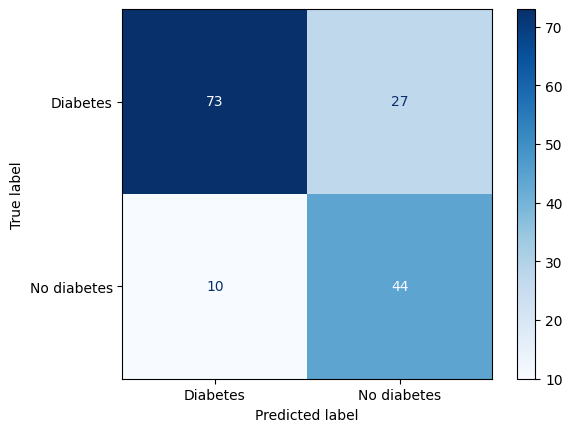

In [242]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Diabetes", "No diabetes"])
disp.plot(cmap='Blues')
plt.show()

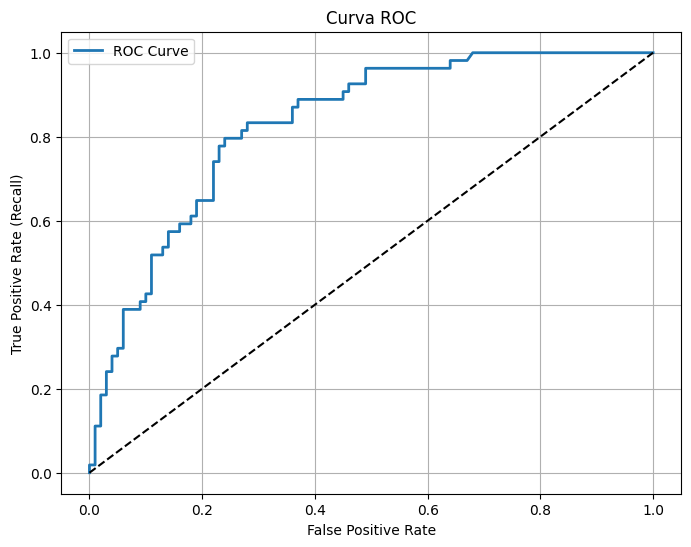

In [243]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

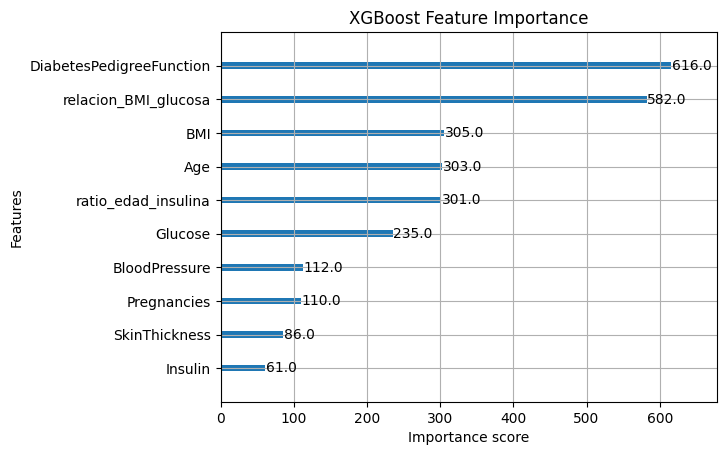

In [244]:
plt.figure(figsize=(10, 6))
plot_importance(best_clf, max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()
